 # Machine Learning

In [1]:
# importando os módulos

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import pymysql

# String de conexão
conn = pymysql.connect(
    host = '127.0.0.1',
    port = 3307,
    user = 'root',
    passwd = 'bootcamp',
    db = 'imoveis_dw'
)

In [3]:
# carregando a tabela do Banco de dados

df = pd.read_sql_query("""SELECT * FROM imoveis""",conn)
df.head()

,cidade,estado,area,num_quartos,num_banheiros,num_andares,garagem,aceita_animais,mobilia,valor_aluguel,valor_condominio,valor_iptu,valor_seguro_incendio
0,São Paulo,SP,70,2,1,7,1,1,1,3300.0,2065.0,211.0,42.0
1,São Paulo,SP,320,4,4,20,0,1,0,4960.0,1200.0,1750.0,63.0
2,Porto Alegre,RS,80,1,1,6,1,1,0,2800.0,1000.0,0.0,41.0
3,Porto Alegre,RS,51,2,1,2,0,1,0,1112.0,270.0,22.0,17.0
4,São Paulo,SP,25,1,1,1,0,0,0,800.0,0.0,25.0,11.0


In [4]:
# reorganizando os atributos

df = df[['cidade', 'estado', 'area', 'num_quartos', 'num_banheiros', 'num_andares', 'garagem', 'aceita_animais', 
        'mobilia', 'valor_condominio', 'valor_iptu', 'valor_seguro_incendio', 'valor_aluguel']]

In [5]:
# tipo dos dados

df.dtypes

cidade                    object
estado                    object
area                       int64
num_quartos                int64
num_banheiros              int64
num_andares                int64
garagem                    int64
aceita_animais             int64
mobilia                    int64
valor_condominio         float64
valor_iptu               float64
valor_seguro_incendio    float64
valor_aluguel            float64
dtype: object

## Aplicando o One Hot Encoder para cidade e estado

**Como não sabemos se existe um maior peso nas cidade e estados, aplicamos o One Hot Encoder.**

In [6]:
df2 = pd.get_dummies(df)

In [7]:
df2.head()

,area,num_quartos,num_banheiros,num_andares,garagem,aceita_animais,mobilia,valor_condominio,valor_iptu,valor_seguro_incendio,valor_aluguel,cidade_Campinas,cidade_Porto Alegre,cidade_Rio de Janeiro,cidade_São Paulo,estado_RJ,estado_RS,estado_SP
0,70,2,1,7,1,1,1,2065.0,211.0,42.0,3300.0,0,0,0,1,0,0,1
1,320,4,4,20,0,1,0,1200.0,1750.0,63.0,4960.0,0,0,0,1,0,0,1
2,80,1,1,6,1,1,0,1000.0,0.0,41.0,2800.0,0,1,0,0,0,1,0
3,51,2,1,2,0,1,0,270.0,22.0,17.0,1112.0,0,1,0,0,0,1,0
4,25,1,1,1,0,0,0,0.0,25.0,11.0,800.0,0,0,0,1,0,0,1


## Detecção e remoção de Outliers da variável target

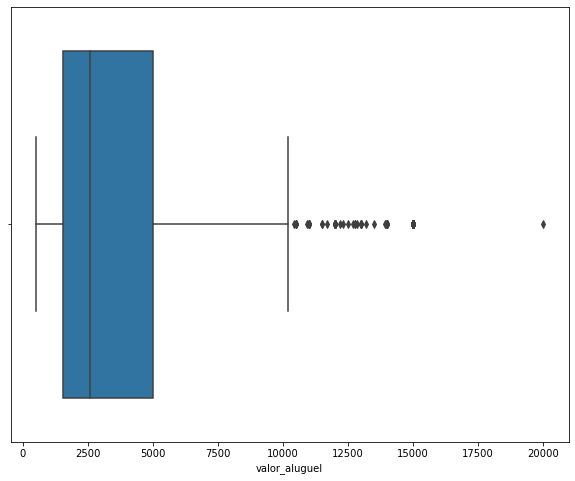

In [8]:
# Detectando OUTLIERS com box plot

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
sns.boxplot(x='valor_aluguel', data=df2)
plt.show()

**Obsermos que acima de 10.000,00 temos OUTLIERS, que podem prejudicar a previsão do modelo.**

### Detecção de OULIERS - IQR

In [9]:
# calculando o iqr

q1 = df2['valor_aluguel'].quantile(.25)

q3 = df2['valor_aluguel'].quantile(.75)

iqr = q3 - q1

iqr

3475.5

In [10]:
# limite inferior e limite superior da variável

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

lower, upper

(-3688.75, 10213.25)

### Filtrando os intervalos interqualíticos

In [11]:
df_clean = df2[(df2['valor_aluguel'] >= lower)]
df_clean = df_clean[(df_clean['valor_aluguel'] <= upper)]

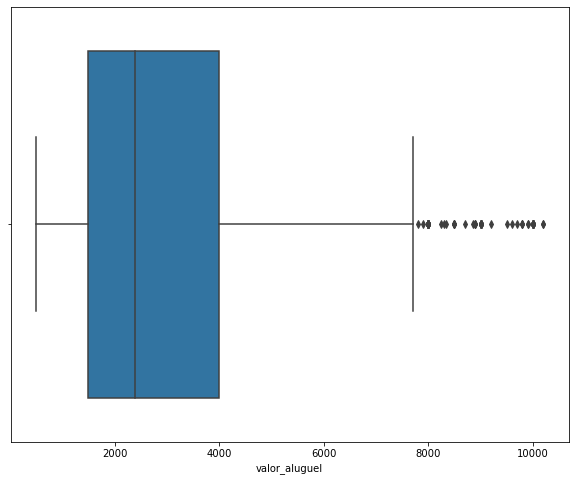

In [12]:
plt.figure(figsize=(10,8))
sns.boxplot(x='valor_aluguel', data=df_clean)
plt.show()

**Obtivemos uma melhora.**

In [13]:
# Salvando data frame final

df3 = df_clean
df3.head()

,area,num_quartos,num_banheiros,num_andares,garagem,aceita_animais,mobilia,valor_condominio,valor_iptu,valor_seguro_incendio,valor_aluguel,cidade_Campinas,cidade_Porto Alegre,cidade_Rio de Janeiro,cidade_São Paulo,estado_RJ,estado_RS,estado_SP
0,70,2,1,7,1,1,1,2065.0,211.0,42.0,3300.0,0,0,0,1,0,0,1
1,320,4,4,20,0,1,0,1200.0,1750.0,63.0,4960.0,0,0,0,1,0,0,1
2,80,1,1,6,1,1,0,1000.0,0.0,41.0,2800.0,0,1,0,0,0,1,0
3,51,2,1,2,0,1,0,270.0,22.0,17.0,1112.0,0,1,0,0,0,1,0
4,25,1,1,1,0,0,0,0.0,25.0,11.0,800.0,0,0,0,1,0,0,1


In [14]:
df3.shape

(918, 18)

# Pré processamento dos dados

In [15]:
# Dividindo os dados em output e input

X = df3.drop(['valor_aluguel'], axis=1)

y = df3['valor_aluguel']
y.tail()

993    2570.0
994    7500.0
997    5000.0
998    2500.0
999    1700.0
Name: valor_aluguel, dtype: float64

## Feature selection

**Selecionando 10 variáveis mais relevantes para o modelo.**

In [16]:
# Feature Selection utilizando Extra Trees

from sklearn.ensemble import ExtraTreesRegressor

# instanciando o modelo
extra_trees = ExtraTreesRegressor()
extra_trees.fit(X, y)

# printando os resultados

for v in extra_trees.feature_importances_:
    print('%f' %(v))

0.019621
0.008285
0.088914
0.003819
0.026276
0.000727
0.002549
0.010183
0.024239
0.810394
0.000715
0.001138
0.000142
0.001317
0.000137
0.001282
0.000264


In [17]:
# printando os resultados maiores

variables = df3.drop(['valor_aluguel'], axis=1).columns[0:17]

print(variables[0], variables[1], variables[2], variables[3], variables[4], variables[6],
      variables[7], variables[8], variables[9], variables[13])

area num_quartos num_banheiros num_andares garagem mobilia valor_condominio valor_iptu valor_seguro_incendio cidade_São Paulo


In [18]:
#criando o dataframe final de treino

final_df = df3[['area', 'num_quartos', 'num_banheiros', 'num_andares',
                'garagem', 'mobilia', 'valor_condominio', 'valor_iptu', 
                'valor_seguro_incendio', 'cidade_São Paulo', 'valor_aluguel']]

## Treinando e validando o modelo com AutoML (Pycaret)

In [19]:
# importando os pacotes para trabalhar com regressão

from pycaret.regression import *

In [20]:
s = setup( final_df 
          ,target = 'valor_aluguel' 
          ,numeric_features = [ 'area', 'num_quartos', 'num_banheiros', 'num_andares'
                               ,'garagem', 'mobilia', 'valor_condominio', 'valor_iptu'
                               ,'valor_seguro_incendio', 'cidade_São Paulo']
          ,log_experiment = True
          ,experiment_name = 'rental_price'
         )

,Description,Value
0,session_id,6124
1,Target,valor_aluguel
2,Original Data,"(918, 11)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(642, 10)"


### Validando os modelos de regressão com k-fold

In [23]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,119.7627,50656.3736,218.0699,0.9904,0.0821,0.0452,0.2000
gbr,Gradient Boosting Regressor,130.1603,53994.3073,220.7046,0.9897,0.0939,0.0525,0.0340
xgboost,Extreme Gradient Boosting,130.1980,60409.5891,238.9749,0.9885,0.0901,0.0501,0.2580
rf,Random Forest Regressor,131.4584,60810.0124,238.4902,0.9885,0.0894,0.0496,0.1940
catboost,CatBoost Regressor,129.8918,65377.1780,247.0714,0.9878,0.0857,0.0501,1.2360
lightgbm,Light Gradient Boosting Machine,145.5884,70151.8950,255.2152,0.9868,0.0904,0.0541,0.1520
dt,Decision Tree Regressor,144.0108,80674.4906,278.9290,0.9846,0.1121,0.0574,0.0120
ada,AdaBoost Regressor,279.3082,152320.9467,388.5146,0.9708,0.1634,0.1213,0.0420
omp,Orthogonal Matching Pursuit,284.4441,187603.0867,431.1788,0.9643,0.1275,0.0909,0.0120
knn,K Neighbors Regressor,1032.4868,2251316.8000,1499.0551,0.5679,0.4075,0.3624,0.0400


In [24]:
# criando o melhor modelo

et_model = create_model('et', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,115.1891,31973.8460,178.8123,0.9933,0.0840,0.0464
1,105.2815,34532.0560,185.8280,0.9938,0.0509,0.0365
2,125.6219,85959.2159,293.1880,0.9825,0.0874,0.0483
3,152.1261,76502.5243,276.5909,0.9871,0.1074,0.0509
4,100.5950,24314.2259,155.9302,0.9952,0.0807,0.0438
Mean,119.7627,50656.3736,218.0699,0.9904,0.0821,0.0452
SD,18.3289,25366.3296,55.6947,0.0048,0.0181,0.0049


In [25]:
## Otimizando o modelo _ hyperparameters tuning

tuned_et = tune_model(et_model, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,119.9672,31225.4371,176.7072,0.9935,0.0855,0.0495
1,115.8479,39186.8348,197.9566,0.9929,0.0540,0.0403
2,131.0860,88335.9001,297.2136,0.9820,0.0891,0.0503
3,175.3177,100967.4825,317.7538,0.9830,0.1195,0.0575
4,119.6018,29730.4385,172.4252,0.9941,0.0874,0.0514
Mean,132.3641,57889.2186,232.4113,0.9891,0.0871,0.0498
SD,22.0726,30451.2415,62.2432,0.0054,0.0207,0.0055


## Explicabilidade do modelo

**Fatores que justifica a utilização do modelo em produção.**

### Visualizando residuais

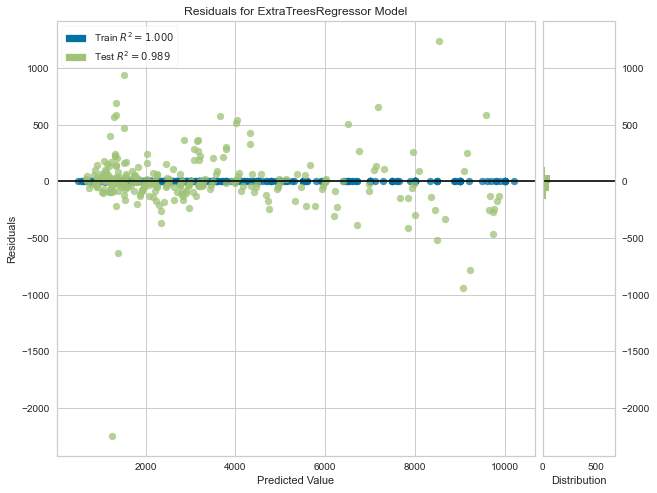

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

plot_model(et_model)

### Visualizando o erro de predição do modelo

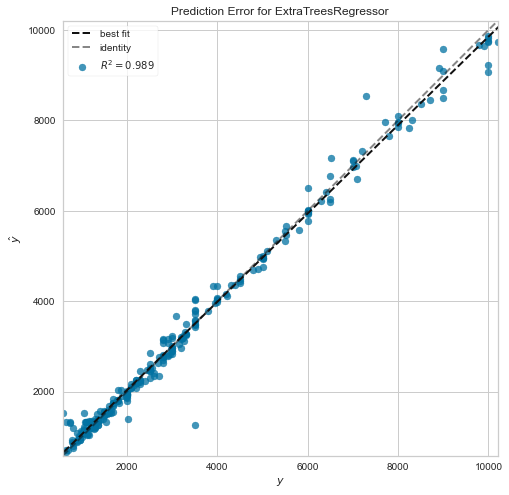

In [27]:
plt.figure(figsize=(10,8))
plot_model(et_model, plot='error')

### Visualizando as features de maior influência

<Figure size 720x576 with 0 Axes>

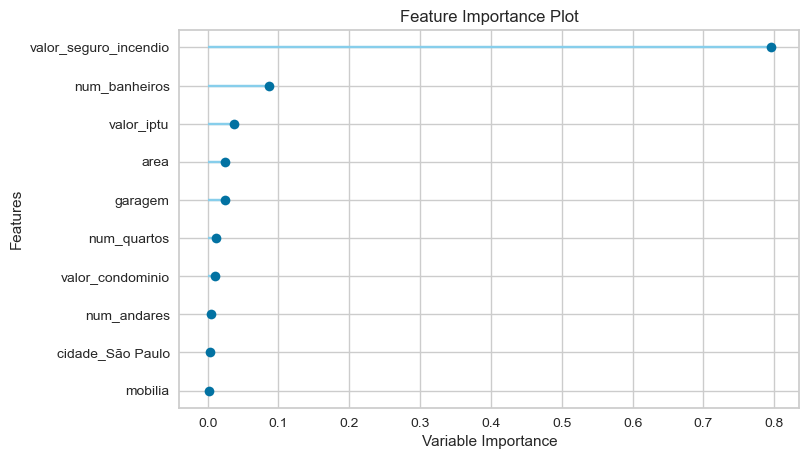

In [28]:
plt.figure(figsize=(10,8))
plot_model(et_model, plot='feature')

## Finalizando o modelo

**Finalize_model(), treina o modelo com todos os dados do dataset.**

In [29]:
final_model = finalize_model(et_model)

## Salvando o modelo em disco

In [30]:
save_model(final_model, 'extra_trees')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['area', 'num_quartos',
                                                           'num_banheiros',
                                                           'num_andares',
                                                           'garagem', 'mobilia',
                                                           'valor_condominio',
                                                           'valor_iptu',
                                                           'valor_seguro_incendio',
                                                           'cidade_São Paulo'],
                                       target='valor_aluguel',
                                   